In [2]:
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.stsmodels import StochasticTrend
from utils.ststtools import stochastic_trend, plot_stochastic_trend

from tqdm.notebook import tqdm 

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

c:\users\migue\documents\proyectos data science\tst_pymc\python\utils\ststtools.py:70: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


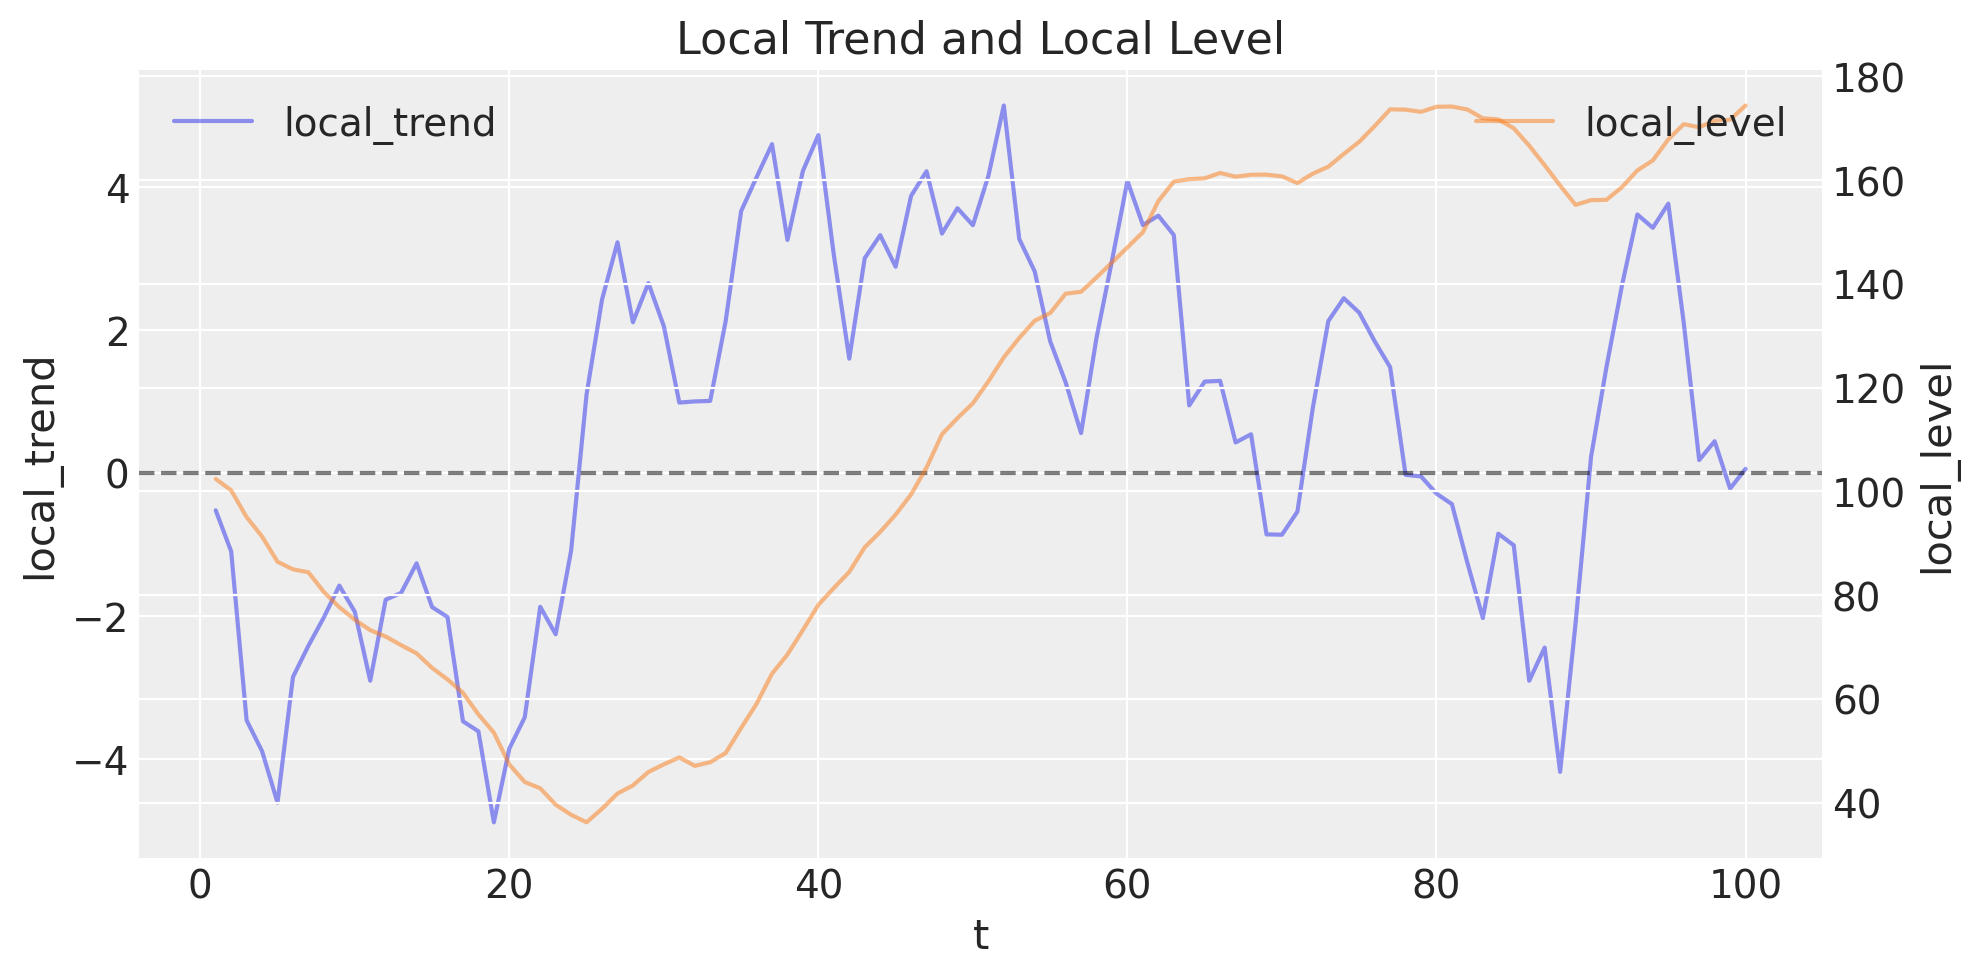

In [4]:
df_stoch_trend = stochastic_trend(
    rng, 
    N = 100, 
    sigma_local_trend = 1, 
    local_trend_0 = 1, 
    sigma_local_level = 1, 
    local_level_0 = 100
    )

plot_stochastic_trend(df_stoch_trend)

In [5]:
df = df_stoch_trend.assign(y = lambda x: x.local_level + rng.normal(0, 1, 100))

t = df["t"].to_numpy()

# Max-min scaling
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

X = pd.DataFrame({"t": t})

y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

In [23]:
model_config = {
            "sigma_local_trend_lam_prior": y_max,
            "sigma_local_level_lam_prior": y_max,
            "sigma_lam_prior": y_max,
        }

sampler_config = {
    'return_inferencedata': True, 
    # 'target_accept': 0.9,
    # 'draws': 12000,
    'chains': 3,
    'nuts_sampler': "numpyro",
    # 'random_seed': rng, # ESTO DA ERROR PORQUE NO ES SERIALIZABLE
    'idata_kwargs': {"log_likelihood": True},
    }

In [24]:
model = StochasticTrend(model_config, sampler_config)

In [25]:
idata = model.fit(X, y)

Compiling...
Compilation time = 0:00:02.967011
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]


Running chain 0:  15%|█▌        | 300/2000 [00:11<00:16, 102.15it/s]

Running chain 0:  20%|██        | 400/2000 [00:14<00:26, 59.78it/s] 


Running chain 0:  25%|██▌       | 500/2000 [00:16<00:27, 53.84it/s]

Running chain 0:  40%|████      | 800/2000 [00:20<00:16, 71.92it/s]

Running chain 0:  55%|█████▌    | 1100/2000 [00:26<00:15, 57.44it/s]

Running chain 0:  65%|██████▌   | 1300/2000 [00:30<00:13, 50.87it/s]

Running chain 2: 100%|██████████| 2000/2000 [00:39<00:00, 50.46it/s] 
Sampling time = 0:00:40.413643
Transforming variables...
Transformation time = 0:00:01.058576
Computing Log Likelihood...
Log Likelihood time = 0:00:00.719647
Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y]
Sampling: [y]


In [26]:
fname = "stochastic_trend_model_v1.nc"
model.save(fname)

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [20]:
model_2 = StochasticTrend.load(fname)

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


In [27]:
# point estimates (the mean) 
pred_mean = model.predict(X)

Sampling: [y]


In [29]:
# full posterior prediction (samples)
pred_samples = model.predict_posterior(X)

Sampling: [y]


KeyError: 'b'

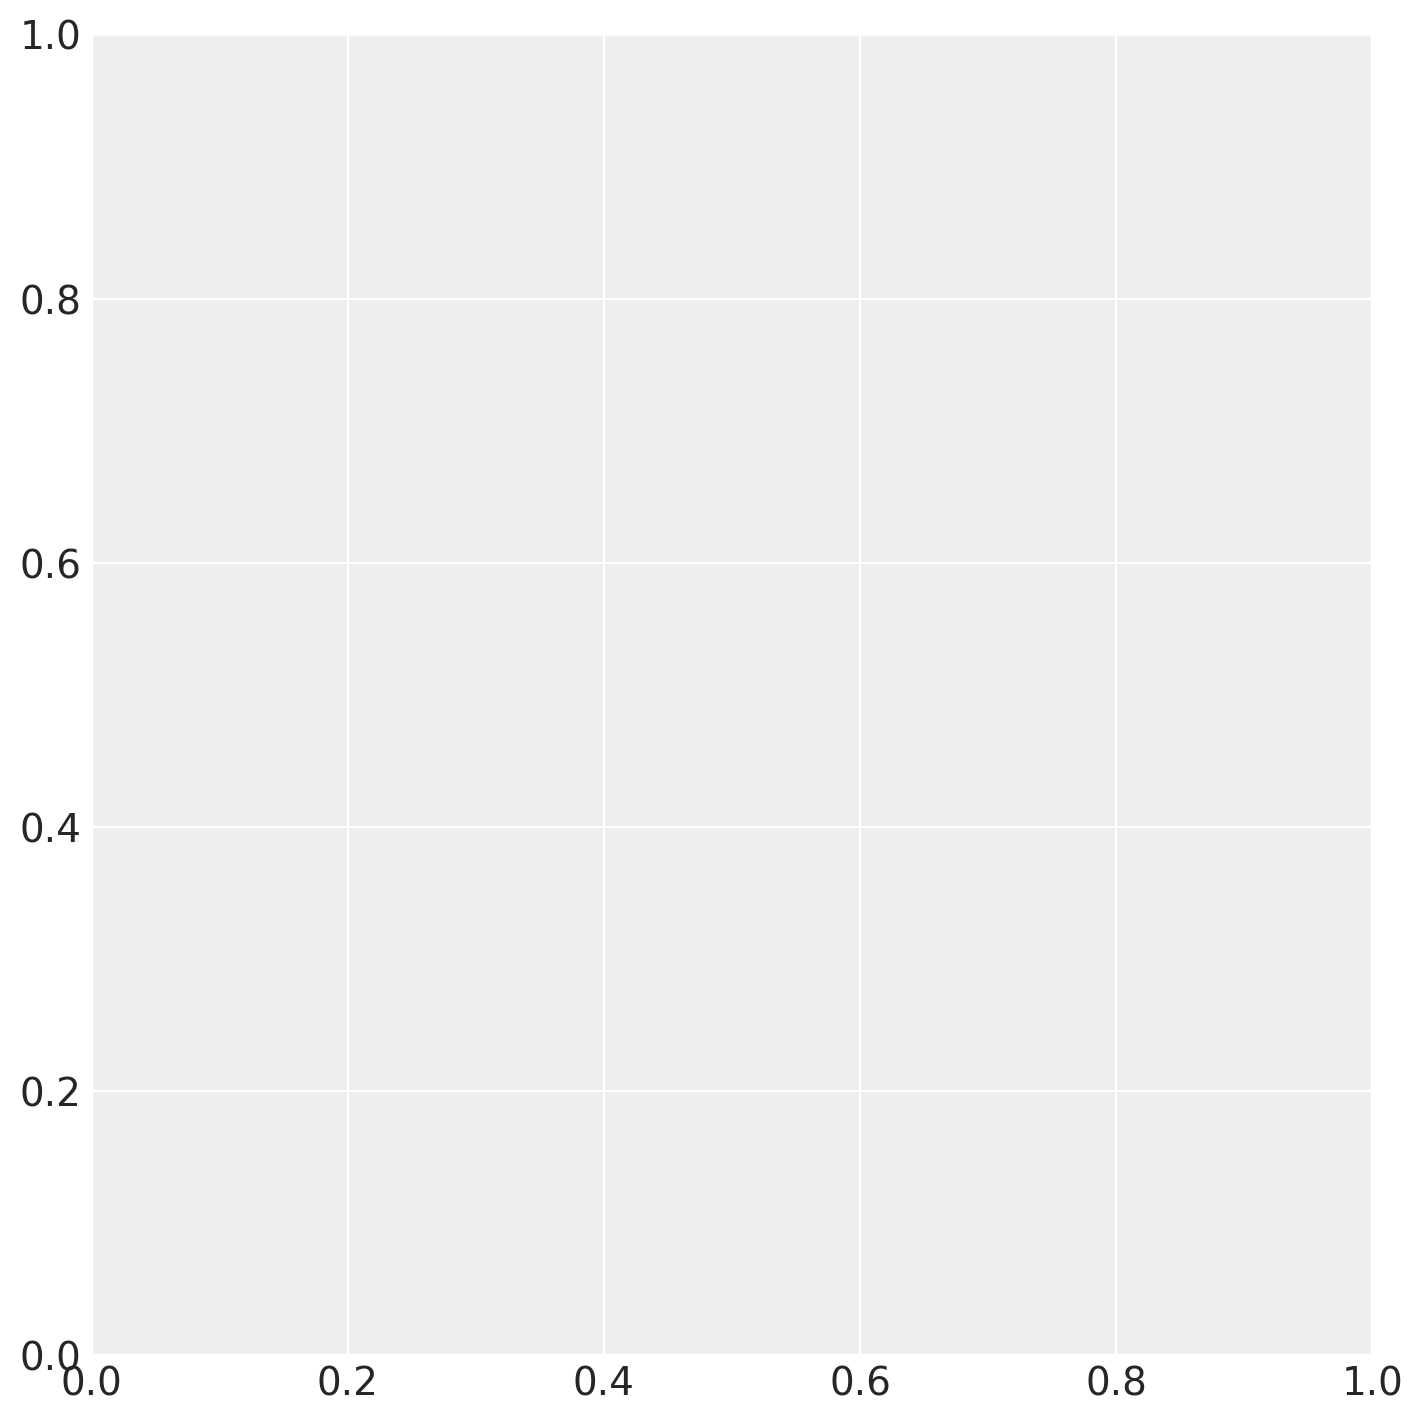

In [31]:
import xarray as xr

fig, ax = plt.subplots(figsize=(7, 7))
posterior = az.extract(idata, num_samples=20)
x_plot = xr.DataArray(np.linspace(1, 2, 100))
y_plot = posterior["b"] * x_plot + posterior["a"]
Line2 = ax.plot(x_plot, y_plot.transpose(), color="C1")
Line1 = ax.plot(x_pred, pred_mean, "x")
ax.set(title="Posterior predictive regression lines", xlabel="x", ylabel="y")
ax.legend(
    handles=[Line1[0], Line2[0]], labels=["predicted average", "inferred regression line"], loc=0
);